# Deep Learning and Dynamical Systems
François Rousseau, IMT Atlantique, Brest

francois.rousseau@imt-atlantique.fr


This hands-on session is dedicated to image registration and template estimation using PyTorch: 

1. Load and visualize data (MNIST)
2. Image registration (based on VoxelMorph)
3. Template estimation
4. Implicit image registration (using SIREN)


In [1]:
!pip install pytorch-lightning
!pip install einops

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Load and visualize 2D data


### **1**. Download MNIST dataset using Pytorch.

We start by looking at 2D MNIST digits before moving to brain MRI data. MNIST comes with the Pytorch framework.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

### **2**. Looking at the data...

Let split the data into three datasets: training, validation, testing. Then, data need to be normalized (here between 0 and 1). Once data are loaded, it's always great to visualize it.

In [3]:
# extract all 3s
digit = 3

# convert to numpy arrays
x_train_all = train_data.data.numpy()
y_train_all = train_data.targets.numpy()
x_test_all = test_data.data.numpy()
y_test_all = test_data.targets.numpy()

x_train = x_train_all[y_train_all == digit, ...]
y_train = y_train_all[y_train_all == digit]
x_test = x_test_all[y_test_all == digit, ...]
y_test = y_test_all[y_test_all == digit]

#%% split train into train and validation

nb_val = 1000  # keep 1,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

#%% normalization

x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255

#%%
nb_vis = 5

# choose nb_vis sample indexes
idx = np.random.choice(x_train.shape[0], nb_vis, replace=False)
example_digits = [f for f in x_train[idx, ...]]
plt.figure()
ax1 = plt.subplot(151)
ax1.imshow(example_digits[0], cmap="gray")
ax2 = plt.subplot(152)
ax2.imshow(example_digits[1], cmap="gray")
ax3 = plt.subplot(153)
ax3.imshow(example_digits[2], cmap="gray")
ax4 = plt.subplot(154)
ax4.imshow(example_digits[3], cmap="gray")
ax5 = plt.subplot(155)
ax5.imshow(example_digits[4], cmap="gray")
plt.show()

Some of the most popular models like to have inputs that are sized as multiples of 2^N for N being the number of layers. Here, we force the images to be size 32 (2x 2^4).

In [4]:
#%%

pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)

shape of training data (5131, 32, 32)


### **3**. Create a Unet network used for the estimation of the deformation field.
Given two images (which we call source and target), the goal is to find the deformation between them. In learning-based methods, we use a network that takes in two images and outputs a dense deformation. This deformation gives us the correspondances between the images, and tells us how to moving the source image to match up with the target image.

Note: Registration also includes (or refers to) affine transforms, but we ignore that here.

We start by building a model from scratch in order to demonstrate the individual components of the network. 

First, we're going to define a CNN model (typically UNet) that takes 2 stacked images to estimate a deformation field.

Complete the following code accordingly.


In [5]:
#%% unet 2d
import torch
import torch.nn as nn 

class Unet(nn.Module):
    def __init__(self, n_channels = 2, n_classes = 2, n_features = 8):
        super(Unet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_features = n_features

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        self.dc1 = double_conv(self.n_channels, self.n_features)
        self.dc2 = double_conv(self.n_features, self.n_features*2)
        self.dc3 = double_conv(self.n_features*2, self.n_features*4)
        self.dc4 = double_conv(self.n_features*6, self.n_features*2)
        self.dc5 = double_conv(self.n_features*3, self.n_features)
        self.mp = nn.MaxPool2d(2)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.out = nn.Conv2d(self.n_features, self.n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.dc1(x)

        x2 = self.mp(x1)
        x2 = self.dc2(x2)

        x3 = self.mp(x2)
        x3 = self.dc3(x3)

        x4 = self.up(x3)
        x4 = torch.cat([x4,x2], dim=1)
        x4 = self.dc4(x4)

        x5 = self.up(x4)
        x5 = torch.cat([x5,x1], dim=1)
        x5 = self.dc5(x5)
        return self.out(x5)

### **4**. Define a spatial transformer used to deform images.
Given a deformation field, we need to compute the loss function (i.e. compute a distance between the target and the deformed source image). To this end, we need a module that deforms an image. This is the purpose of the SpatialTransformer class.

In [6]:
#%%
import torch.nn.functional as F
# code from voxelmorph repo
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, mode='bilinear'):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor)

        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict
        self.register_buffer('grid', grid)

    def forward(self, src, flow):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode)


### **5**. Using Pytorch lightning, define a network for unsupervised registration.
Now, we have all the modules to set up a network dedicated to image registration. Using Pytorch lightning, define such a model. 

In [7]:
 
import pytorch_lightning as pl

train_losses = []

class morph_model(pl.LightningModule):
  def __init__(self, shape):
    super().__init__()   
    self.shape = shape
    self.unet_model = Unet()
    self.transformer = SpatialTransformer(size=shape)

  def forward(self,source,target):
    #source and target are two 2D images
    #concatenate images for unet
    x = torch.cat([source,target],dim=1)
    flow = self.unet_model(x)
    y_source = self.transformer(source, flow)
    
    return y_source, flow 

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    return optimizer

  def training_step(self, batch, batch_idx):
    source, target = batch

    y_source,flow = self(source,target)
    
    loss = F.mse_loss(target,y_source)
    train_losses.append(loss.cpu().detach().numpy())
    return loss 


### **6**. Define a CustomDataSet dedicated to image registration.
To train, we need to make sure the data is in the right format and fed to the model the way we want it such that pytorch models can be trained.

Let's code a data generator based on the MNIST data using the CustomDataSet class.


In [8]:
from torch.utils.data import Dataset
class CustomDataSet(Dataset):
  def __init__(self, X):
    self.X = X
    self.len = len(self.X)

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    index_source = torch.randint(self.len,(1,))
    index_target = torch.randint(self.len,(1,))

    #_source = torch.unsqueeze(self.X[index_source],0)
    #_target = torch.unsqueeze(self.X[index_target],0)
    _source = self.X[index_source][0]
    _target = self.X[index_target][0]
    
    return _source, _target

#%%
batch_size = 32
n_training = x_train.shape[0]
source = torch.reshape(torch.Tensor(x_train[:n_training, ...]),(n_training,1,32,32))

trainset = CustomDataSet(source)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)

### **7**. Train the network and visualize the evolution of the loss wrt epochs.

In [9]:
#%%
from pytorch_lightning.loggers import TensorBoardLogger
n_epochs = 10

net = morph_model(shape=(32,32))

trainer = pl.Trainer(gpus=1, 
                     max_epochs=n_epochs,
                     logger=TensorBoardLogger(save_dir='lightning_logs', default_hp_metric=False, log_graph=True))
trainer.fit(net, trainloader)     

#%%
plt.figure()
plt.plot(train_losses)
plt.title('loss function', size=10)
plt.xlabel('steps', size=10)
plt.ylabel('loss value', size=10)  

/home/rousseau/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | unet_model  | Unet               | 30.0 K
1 | transformer | SpatialTransformer | 0     
---------------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Text(0, 0.5, 'loss value')

### **8**. Let's define visualization functions (images and deformation fields).

In [10]:
def visu_img(imgs):
  n_imgs = len(imgs)
  fig, axs = plt.subplots(1, n_imgs)
  if n_imgs == 1:
    axs = [axs]    
  for i in range(n_imgs):
    axs[i].imshow(imgs[i], interpolation="nearest", cmap="gray")    
  plt.show()

def visu_flow(flows):
  n_flows = len(flows)
  fig, axs = plt.subplots(1, n_flows)
  if n_flows == 1:
    axs = [axs]    
  for i in range(n_flows):
    u, v = flows[i][0,0,:,:],flows[i][0,1,:,:]
    axs[i].quiver(u,v)
  plt.show()

### **9**. Apply the trained network and visualize the deformed image (and the deformation field).

With pair-wise optimization methods (like most classical methods), to register a new pair you would need to optimize a deformation field.

With learning based registration, we simply evaluate the network for a new input pair.

Applies the trained network on two images (same digit: 3).

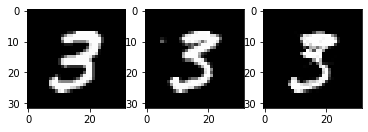

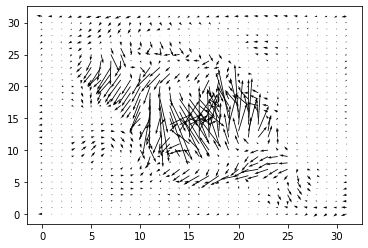

In [11]:
n_source = 0
n_target = 6
source_np = x_train[n_source, ...]
target_np = x_train[n_target, ...]

source = torch.reshape(torch.Tensor(source_np),(1,1,32,32))
target =  torch.reshape(torch.Tensor(target_np),(1,1,32,32))

y_source, flow = net.forward(source,target)
y_source_np = np.reshape(y_source.cpu().detach().numpy(),(32,32))
flow_np = flow.cpu().detach().numpy()

visu_img([source_np, target_np, y_source_np])
visu_flow([flow_np])

### How to get a smoother estimated deformation field?

To estimate a smoother deformation field, a loss based on the gradient of the deformation field can be added. More specifically, one can penalize the norm of the spatial gradient of the flow.


In [12]:
# Code adapted from Voxelmorph

class Grad2d:
  """
  N-D gradient loss (used for the smoothness of the flow).
  """

  def __init__(self, penalty='l2'):
    self.penalty = penalty

  def forward(self, x):
    dy = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :])
    dx = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1])

    if self.penalty == 'l2':
      dy = dy * dy
      dx = dx * dx

    d = torch.mean(dx) + torch.mean(dy)
    grad = d / 2.0

    return grad

class smooth_morph_model(pl.LightningModule):
  def __init__(self, shape):
    super().__init__()   
    self.shape = shape
    self.unet_model = Unet()
    self.transformer = SpatialTransformer(size=shape)
    self.lambda_grad_flow  = 0.1

  def forward(self,source,target):
    #source and target are two 2D images
    #concatenate images for unet
    x = torch.cat([source,target],dim=1)
    flow = self.unet_model(x)
    y_source = self.transformer(source, flow)
    
    return y_source, flow 

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    return optimizer

  def training_step(self, batch, batch_idx):
    source, target = batch

    y_source,flow = self(source,target)
    
    loss = F.mse_loss(target,y_source)
    
    if self.lambda_grad_flow > 0:
      loss += self.lambda_grad_flow * Grad2d().forward(flow) 
    
    train_losses.append(loss.cpu().detach().numpy())
    return loss 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | unet_model  | Unet               | 30.0 K
1 | transformer | SpatialTransformer | 0     
---------------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


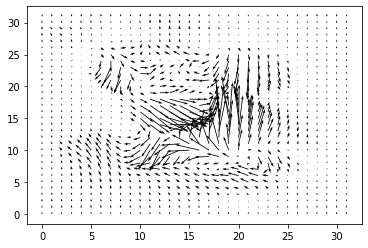

In [13]:
n_epochs = 10

smooth_net = smooth_morph_model(shape=(32,32))

smooth_trainer = pl.Trainer(gpus=1, 
                     max_epochs=n_epochs,
                     logger=TensorBoardLogger(save_dir='lightning_logs', default_hp_metric=False, log_graph=True))
smooth_trainer.fit(smooth_net, trainloader)  

n_source = 0
n_target = 6
source_np = x_train[n_source, ...]
target_np = x_train[n_target, ...]

source = torch.reshape(torch.Tensor(source_np),(1,1,32,32))
target =  torch.reshape(torch.Tensor(target_np),(1,1,32,32))

y_source, flow = smooth_net.forward(source,target)
y_source_np = np.reshape(y_source.cpu().detach().numpy(),(32,32))
flow_np = flow.cpu().detach().numpy()

visu_img([source_np, target_np, y_source_np])
visu_flow([flow_np])

### **10**. What about generalization? Apply the trained networt on a different digit class.

How do learning-based methods generalize beyond training distribution ?

An important caveat to learning-based registration is that they will, in general, only register samples fromt he distribution they've been trained from.

So, what happens if we register two 5's?


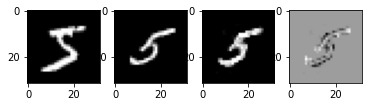

In [14]:
#%% Generalization on another digit
digit = 5

x_fives = x_train_all[y_train_all == digit, ...]
x_fives = np.pad(x_fives, pad_amount, 'constant')

n_source = 0
n_target = 2
source = torch.reshape(torch.Tensor(x_fives[n_source, ...]),(1,1,32,32))
target =  torch.reshape(torch.Tensor(x_fives[n_target, ...]),(1,1,32,32))

warped, flow = net.forward(source,target)

source_np = source.cpu().detach().numpy()
target_np = target.cpu().detach().numpy()
warped_np = warped.cpu().detach().numpy()
flow_np = flow.cpu().detach().numpy()

plt.figure()
ax1 = plt.subplot(141)
ax1.imshow(np.reshape(source_np,(32,32)), cmap="gray")
ax2 = plt.subplot(142)
ax2.imshow(np.reshape(target_np,(32,32)), cmap="gray")
ax3 = plt.subplot(143)
ax3.imshow(np.reshape(warped_np,(32,32)), cmap="gray")
ax4 = plt.subplot(144)
ax4.imshow(np.reshape(target_np-warped_np,(32,32)), cmap="gray")
plt.show()

### **11**. Modify the registration network by introducing stationary velocity fields for transform modeling.

The deformation field is the integration of a stationary velocity field. To integrate the velocity, we make use of the VecInt class from VoxelMorph library.

Define a SVF model by modifying the way the deformation field is computed.

In [15]:
#%% Diffeomorphism (SVF)

#from voxelmorph repo
class VecInt(nn.Module):
    """
    Integrates a vector field via scaling and squaring.
    """

    def __init__(self, inshape, nsteps):
        super().__init__()

        assert nsteps >= 0, 'nsteps should be >= 0, found: %d' % nsteps
        self.nsteps = nsteps
        self.scale = 1.0 / (2 ** self.nsteps)
        self.transformer = SpatialTransformer(inshape)

    def forward(self, vec):
        vec = vec * self.scale
        for _ in range(self.nsteps):
            vec = vec + self.transformer(vec, vec)
        return vec


class SVF_model(pl.LightningModule):
  def __init__(self, shape, int_steps = 7):
    super().__init__()   
    self.shape = shape
    self.unet_model = Unet()
    self.transformer = SpatialTransformer(size=shape)
    self.int_steps = int_steps #number of integration step (i.e. flow is integrated from velocity fields). 
    self.vecint = VecInt(inshape=shape, nsteps=int_steps)
    
  def forward(self,source,target):
    #concatenate images for unet
    x = torch.cat([source,target],dim=1)
    flow = self.unet_model(x)
    
    if self.int_steps > 0:
      flow = self.vecint(flow)
    
    y_source = self.transformer(source, flow)
    
    return y_source, flow 

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    return optimizer

  def training_step(self, batch, batch_idx):
    source, target = batch

    y_source,flow = self(source,target)
    
    loss = F.mse_loss(target,y_source)
    return loss 


### **12**. Study the performances of the SVF network.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | unet_model  | Unet               | 30.0 K
1 | transformer | SpatialTransformer | 0     
2 | vecint      | VecInt             | 0     
---------------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


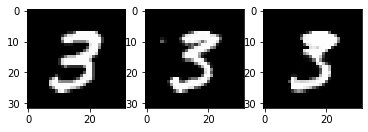

In [16]:
svf_net = SVF_model(shape=(32,32))

svf_trainer = pl.Trainer(gpus=1, 
                     max_epochs=n_epochs,
                     logger=TensorBoardLogger(save_dir='lightning_logs', default_hp_metric=False, log_graph=True))
svf_trainer.fit(svf_net, trainloader)     

#%%
n_source = 0
n_target = 6
source_np = x_train[n_source, ...]
target_np = x_train[n_target, ...]

source = torch.reshape(torch.Tensor(source_np),(1,1,32,32))
target =  torch.reshape(torch.Tensor(target_np),(1,1,32,32))

y_source, flow = svf_net.forward(source,target)
y_source_np = np.reshape(y_source.cpu().detach().numpy(),(32,32))
flow_np = flow.cpu().detach().numpy()

visu_img([source_np, target_np, y_source_np])
visu_flow([flow_np])


### **13**. Extend the SVF network to deal with bidirectional flows.

SVF-based modeling is a way to build diffeomorphisms (an invertible function that maps one differentiable manifold to another such that both the function and its inverse are smooth). We can make use of this property to estimate the backward deformation field by integrating the backward velocity field (which can be defined as the opposite of the forward velocity field).

Modify the previous network to introduce forward and backward deformation fields into the loss function.

In [17]:
#%% Bidirectional registration
class SVF_bidir_model(pl.LightningModule):
  def __init__(self, shape, int_steps = 7):
    super().__init__()   
    self.shape = shape
    self.unet_model = Unet()
    self.transformer = SpatialTransformer(size=shape)
    self.int_steps = int_steps #number of integration step (i.e. flow is integrated from velocity fields). 
    self.vecint = VecInt(inshape=shape, nsteps=int_steps)
    
  def forward(self,source,target):
    #concatenate images for unet
    x = torch.cat([source,target],dim=1)
    forward_velocity = self.unet_model(x)
    
    backward_velocity = -forward_velocity
    if self.int_steps > 0:
      forward_flow = self.vecint(forward_velocity)
      backward_flow= self.vecint(backward_velocity)
    
    y_source = self.transformer(source, forward_flow)
    y_target = self.transformer(target, backward_flow)
    
    return y_source, y_target 

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    return optimizer

  def training_step(self, batch, batch_idx):
    source, target = batch

    y_source,y_target = self(source,target)
    
    loss = F.mse_loss(target,y_source) + F.mse_loss(y_target,source)
    #self.log('train_loss', loss)
    return loss 


### **14**. Study of the bidirectional SVF network.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | unet_model  | Unet               | 30.0 K
1 | transformer | SpatialTransformer | 0     
2 | vecint      | VecInt             | 0     
---------------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


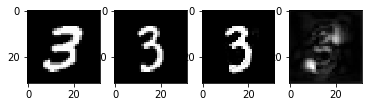

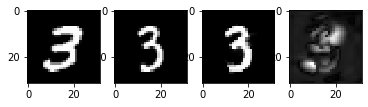

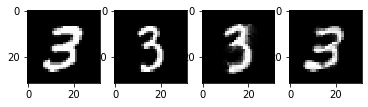

In [18]:
svf_bidir_net = SVF_bidir_model(shape=(32,32))

svf_bidir_trainer = pl.Trainer(gpus=1, 
                     max_epochs=n_epochs,
                     logger=TensorBoardLogger(save_dir='lightning_logs', default_hp_metric=False, log_graph=True))
svf_bidir_trainer.fit(svf_bidir_net, trainloader)  

#%%
n_source = 0
n_target = 10

source_np = x_train[n_source, ...]
target_np = x_train[n_target, ...]

source = torch.reshape(torch.Tensor(source_np),(1,1,32,32))
target =  torch.reshape(torch.Tensor(target_np),(1,1,32,32))

y_source, flow = net.forward(source,target)
y_source_np = np.reshape(y_source.cpu().detach().numpy(),(32,32))
flow_np = flow.cpu().detach().numpy()
flow_norm = np.reshape(np.linalg.norm(flow_np, axis=1),(32,32))
visu_img([source_np, target_np, y_source_np, flow_norm])

y_source, flow = svf_net.forward(source,target)
y_source_np = np.reshape(y_source.cpu().detach().numpy(),(32,32))
flow_np = flow.cpu().detach().numpy()
flow_norm = np.reshape(np.linalg.norm(flow_np, axis=1),(32,32))
visu_img([source_np, target_np, y_source_np, flow_norm])

y_source, y_target = svf_bidir_net.forward(source,target)
y_source_np = np.reshape(y_source.cpu().detach().numpy(),(32,32))
y_target_np = np.reshape(y_target.cpu().detach().numpy(),(32,32))
visu_img([source_np, target_np, y_source_np,y_target_np])


## Atlas building

### **1**. Define a network for atlas building.

Modify the previous bidirectional SVF model by adding: 1) a learnable image (i.e. the template), 2) a loss related to definition of a template.

In [19]:
class atlas_building_model(pl.LightningModule):
  def __init__(self, shape, int_steps = 7, init_atlas = None):
    super().__init__()  
    self.shape = shape

    self.unet_model = Unet()
    self.transformer = SpatialTransformer(size=shape)
    if init_atlas is None:
      self.atlas = nn.Parameter(torch.unsqueeze(torch.randn(shape) / 100,0))
    else:
      self.atlas = nn.Parameter(torch.unsqueeze(torch.Tensor(init_atlas),0))
    self.int_steps = int_steps
    self.vecint = VecInt(inshape=shape, nsteps=int_steps)

  def forward(self,source):
    target = torch.unsqueeze(self.atlas,0).expand(source.shape[0],-1,-1,-1) #atlas is set as the target
    x = torch.cat([source,target],dim=1) 
    forward_velocity = self.unet_model(x)
    
    backward_velocity = -forward_velocity
    if self.int_steps > 0:
      forward_flow = self.vecint(forward_velocity)
      backward_flow= self.vecint(backward_velocity)
    
    y_source = self.transformer(source, forward_flow)
    y_target = self.transformer(target, backward_flow)
    
    return y_source, y_target, forward_flow 

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    return optimizer

  def training_step(self, batch, batch_idx):
    source,tmp = batch

    y_source,y_target,forward_flow = self(source)
    
    loss = F.mse_loss(self.atlas,y_source) + F.mse_loss(y_target,source) + 0.01 * torch.norm(torch.mean(forward_flow,0),p=2)

    return loss 


Instantiate an atlas building model and visualize the initial template.

torch.Size([1, 32, 32])


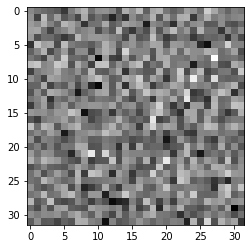

In [20]:
atlas_building_net = atlas_building_model(shape=(32,32))

template = atlas_building_net.atlas
print(template.shape)
plt.figure()
plt.imshow(template[0,...].cpu().detach().numpy(), cmap="gray")
plt.show()

### **2**. Train the atlas building network.

In [21]:
#%%
n_epochs = 25

atlas_building_trainer = pl.Trainer(gpus=1, 
                     max_epochs=n_epochs,
                     logger=TensorBoardLogger(save_dir='lightning_logs', default_hp_metric=False, log_graph=True))
atlas_building_trainer.fit(atlas_building_net, trainloader)  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | unet_model  | Unet               | 30.0 K
1 | transformer | SpatialTransformer | 0     
2 | vecint      | VecInt             | 0     
---------------------------------------------------
31.0 K    Trainable params
0         Non-trainable params
31.0 K    Total params
0.124     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


### **3**. Visualise the estimated atlas.

torch.Size([1, 32, 32])


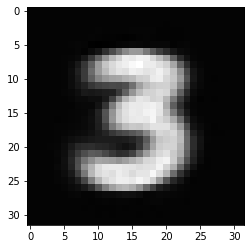

In [22]:
template = atlas_building_net.atlas
print(template.shape)
plt.figure()
plt.imshow(template[0,...].cpu().detach().numpy(),cmap="gray")
plt.show()

### **4**. Application to 2D MRI data.

We will now register slightly more realistic data - MRIs of the brain. To be able to train and easily register during this tutorial, we will first extract the middle slice of brain scans.

Note that because this task does not capture deformations in the third dimensions, certain correspondances are not exactly possible. Nonetheless, this exercise will illustrate registration with more realistic complex images.

The brains have been intensity-normalized affinely aligned, and skull-stripped with FreeSurfer, to enable focusing on deformable registration.


--2022-09-05 10:22:20--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16644702 (16M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  15,87M  6,92MB/s    in 2,3s    

2022-09-05 10:22:23 (6,92 MB/s) - ‘data.tar.gz’ saved [16644702/16644702]

brain_2d_no_smooth.h5
brain_2d_smooth.h5
brain_3d.h5
fs_rgb.npy
subj1.npz
subj2.npz
tutorial_data.npz
train shape: (208, 192, 160)


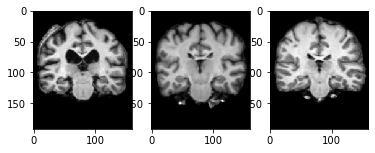

In [23]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz
npz = np.load('tutorial_data.npz')

#from os.path import expanduser
#home = expanduser("~")
#npz = np.load(home+'/Sync/Data/tutorial_data/tutorial_data.npz')

brains = npz['train']

vol_shape = brains.shape[1:]
print('train shape:', brains.shape)

visu_img([brains[0,...],brains[1,...],brains[3,...]])

n_training = brains.shape[0]
source = torch.reshape(torch.Tensor(brains[:n_training, ...]),(n_training,1,192,160))
trainset = CustomDataSet(source)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)


Setup a model and visualize the initial template estimate.

torch.Size([1, 192, 160])


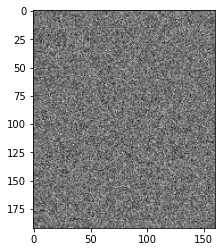

In [25]:
brain_atlas_building_net = atlas_building_model(shape=(192,160))#, init_atlas = mean_brain)

template = brain_atlas_building_net.atlas
print(template.shape)
plt.figure()
plt.imshow(template[0,...].cpu().detach().numpy(),cmap="gray")
plt.show()

Run the training step and visualize the estimated template.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | unet_model  | Unet               | 30.0 K
1 | transformer | SpatialTransformer | 0     
2 | vecint      | VecInt             | 0     
---------------------------------------------------
60.7 K    Trainable params
0         Non-trainable params
60.7 K    Total params
0.243     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


torch.Size([1, 192, 160])


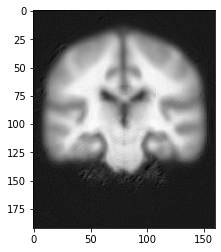

In [48]:
n_epochs = 1000

brain_atlas_building_trainer = pl.Trainer(gpus=1, 
                     max_epochs=n_epochs,
                     logger=TensorBoardLogger(save_dir='lightning_logs', default_hp_metric=False, log_graph=True))

brain_atlas_building_trainer.fit(brain_atlas_building_net, trainloader)  

template = brain_atlas_building_net.atlas
print(template.shape)
plt.figure()
plt.imshow(template[0,...].cpu().detach().numpy(),cmap="gray")
plt.show()

## Implicit representation of the deformation fields for pairwise registration

We investigate in this section the use of neural fields (i.e. implicit representation) of the deformation fields for image registration. For each new image pair, we optimize a network that takes as input any spatial coordinate and provide as output a function value. 

Let first define a SIREN network.





In [40]:
#%% Code from SIREN repo modified for lightning
import math
from einops import rearrange

def exists(val):
  return val is not None

def cast_tuple(val, repeat = 1):
  return val if isinstance(val, tuple) else ((val,) * repeat)
  
class Sine(nn.Module):
  def __init__(self, w0 = 1.):
    super().__init__()
    self.w0 = w0
  def forward(self, x):
    return torch.sin(self.w0 * x)

# siren layer
class Siren(nn.Module):
  def __init__(self, dim_in, dim_out, w0 = 1., c = 6., is_first = False, use_bias = True, activation = None):
    super().__init__()
    self.dim_in = dim_in
    self.is_first = is_first

    weight = torch.zeros(dim_out, dim_in)
    bias = torch.zeros(dim_out) if use_bias else None
    self.init_(weight, bias, c = c, w0 = w0)

    self.weight = nn.Parameter(weight)
    self.bias = nn.Parameter(bias) if use_bias else None
    self.activation = Sine(w0) if activation is None else activation

  def init_(self, weight, bias, c, w0):
    dim = self.dim_in

    w_std = (1 / dim) if self.is_first else (math.sqrt(c / dim) / w0)
    weight.uniform_(-w_std, w_std)

    if exists(bias):
        bias.uniform_(-w_std, w_std)

  def forward(self, x):
    out =  F.linear(x, self.weight, self.bias)
    out = self.activation(out)
    return out

# siren network
class SirenNet(nn.Module):
  def __init__(self, dim_in=2, dim_hidden=128, dim_out=2, num_layers=2, w0 = 1., w0_initial = 30., use_bias = True, final_activation = None):
    super().__init__()
    self.num_layers = num_layers
    self.dim_hidden = dim_hidden

    self.layers = nn.ModuleList([])
    for ind in range(num_layers):
        is_first = ind == 0
        layer_w0 = w0_initial if is_first else w0
        layer_dim_in = dim_in if is_first else dim_hidden

        self.layers.append(Siren(
            dim_in = layer_dim_in,
            dim_out = dim_hidden,
            w0 = layer_w0,
            use_bias = use_bias,
            is_first = is_first
        ))

    final_activation = nn.Identity() if not exists(final_activation) else final_activation
    self.last_layer = Siren(dim_in = dim_hidden, dim_out = dim_out, w0 = w0, use_bias = use_bias, activation = final_activation)

  def forward(self, x, mods = None):
    mods = cast_tuple(mods, self.num_layers)

    for layer, mod in zip(self.layers, mods):
      x = layer(x)

      if exists(mod):
        x *= rearrange(mod, 'd -> () d')

    return self.last_layer(x)


This SIREN network is now added in a registration module.

In [41]:
class siren_morph_model(pl.LightningModule):
  def __init__(self, shape):
    super().__init__()   
    self.shape = shape
    self.siren_model = SirenNet()
    self.transformer = SpatialTransformer(size=shape)
    
    #create 2d grid
    x = torch.linspace(-1, 1, steps=self.shape[0])
    y = torch.linspace(-1, 1, steps=self.shape[1])
    mgrid = torch.stack(torch.meshgrid(x,y), dim=-1)
    self.grid = torch.Tensor(mgrid.reshape(-1,2))

  def forward(self,source,target):
    #source and target are two 2D images
    #siren is applied on a regular grid (list of 2D coordinates)
    flow = torch.reshape(self.siren_model(self.grid),(1,2,self.shape[0],self.shape[1]))
    y_source = self.transformer(source, flow)
    
    return y_source, flow 

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    return optimizer

  def training_step(self, batch, batch_idx):
    source, target = batch

    y_source,flow = self(source,target)
    
    loss = F.mse_loss(target,y_source)
    train_losses.append(loss.cpu().detach().numpy())
    return loss 


Since continuous representations rely on coordinate-based neural network, a training step is required for each new pair of images. Define a custom dataset containing only two images and train the registration network based on SIREN modeling.

In [42]:
class TwoDataSet(Dataset):
  def __init__(self, X):
    self.X = X
    self.len = len(self.X)

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    index_source = 0
    index_target = 1

    _source = self.X[index_source]
    _target = self.X[index_target]
    
    return _source, _target   

n_source = 0
n_target = 10

source_np = x_train[n_source, ...]
target_np = x_train[n_target, ...]

source = torch.reshape(torch.Tensor(source_np),(1,1,32,32))
target =  torch.reshape(torch.Tensor(target_np),(1,1,32,32))

x_train_reg = torch.cat([source,target],dim=0)
batch_size_reg = 1
trainset_reg = TwoDataSet(x_train_reg)
trainloader_reg = torch.utils.data.DataLoader(trainset_reg, batch_size=batch_size_reg)   


Train the model.

In [43]:
n_epochs = 500

siren_net = siren_morph_model(shape=(32,32))

siren_trainer = pl.Trainer(gpus=0, 
                     max_epochs=n_epochs,
                     logger=TensorBoardLogger(save_dir='lightning_logs', default_hp_metric=False, log_graph=True))
siren_trainer.fit(siren_net, trainloader_reg)     


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type               | Params
---------------------------------------------------
0 | siren_model | SirenNet           | 17.2 K
1 | transformer | SpatialTransformer | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


Visualize the images (source, target, warped source) and the corresponding deformation fields.

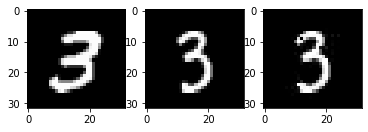

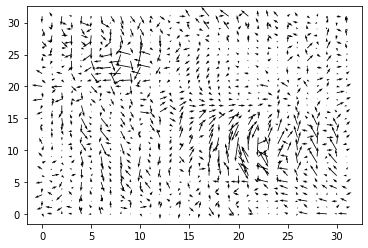

In [44]:
n_source = 0
n_target = 10
source_np = x_train[n_source, ...]
target_np = x_train[n_target, ...]

source = torch.reshape(torch.Tensor(source_np),(1,1,32,32))
target =  torch.reshape(torch.Tensor(target_np),(1,1,32,32))

y_source, flow = siren_net.forward(source,target)
y_source_np = np.reshape(y_source.cpu().detach().numpy(),(32,32))
flow_np = flow.cpu().detach().numpy()

visu_img([source_np, target_np, y_source_np])
visu_flow([flow_np])   

Implicit representation can be used to add constraints on the estimated deformation fields, such as jacobian regularizer without introducing numerical errors.

$$
    \mathcal{L}_{jac}(\Phi) = \int_{\Omega} | 1 - \det \nabla \Phi | d{\bf x}
$$ 

In [45]:
#Modified code from https://github.com/MIAGroupUT/IDIR
def gradient(input_coords, output, grad_outputs=None):
    """Compute the gradient of the output wrt the input."""

    grad_outputs = torch.ones_like(output)
    grad = torch.autograd.grad(
        output, [input_coords], grad_outputs=grad_outputs, create_graph=True
    )[0]
    return grad

def compute_jacobian_matrix(input_coords, output, add_identity=True):
    """Compute the Jacobian matrix of the output wrt the input."""

    jacobian_matrix = torch.zeros(input_coords.shape[0], 2, 2)
    for i in range(2):
        jacobian_matrix[:, i, :] = gradient(input_coords, output[:, i])
        if add_identity:
            jacobian_matrix[:, i, i] += torch.ones_like(jacobian_matrix[:, i, i])
    return jacobian_matrix

def compute_jacobian_loss(input_coords, output, batch_size=None):
    """Compute the jacobian regularization loss."""

    # Compute Jacobian matrices
    jac = compute_jacobian_matrix(input_coords, output)

    # Compute determinants and take norm
    loss = torch.det(jac) - 1
    loss = torch.linalg.norm(loss, 1)

    return loss / batch_size

Modify the implicit registration model to add a jacobian-based loss.

In [46]:
class siren_reg_morph_model(pl.LightningModule):
  def __init__(self, shape):
    super().__init__()   
    self.shape = shape
    self.siren_model = SirenNet()
    self.transformer = SpatialTransformer(size=shape)
    self.alpha = 0.00001
    
    #create 2d grid
    x = torch.linspace(-1, 1, steps=self.shape[0])
    y = torch.linspace(-1, 1, steps=self.shape[1])
    mgrid = torch.stack(torch.meshgrid(x,y), dim=-1)
    self.grid = torch.Tensor(mgrid.reshape(-1,2))
    self.grid = self.grid.requires_grad_(True)

  def forward(self,source,target):
    #source and target are two 2D images
    #siren is applied on a regular grid (list of 2D coordinates)
    flow = torch.reshape(self.siren_model(self.grid),(1,2,self.shape[0],self.shape[1]))
    y_source = self.transformer(source, flow)
    
    return y_source, flow 

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    return optimizer

  def training_step(self, batch, batch_idx):
    source, target = batch

    y_source,flow = self(source,target)
    
    loss = F.mse_loss(target,y_source) + self.alpha * compute_jacobian_loss(self.grid,flow,batch_size=1)
    train_losses.append(loss.cpu().detach().numpy())
    return loss 


Do the training and visualize the results.

In [47]:
n_epochs = 5000

siren_reg_net = siren_reg_morph_model(shape=(32,32))

siren_reg_trainer = pl.Trainer(gpus=0, 
                     max_epochs=n_epochs,
                     logger=TensorBoardLogger(save_dir='lightning_logs', default_hp_metric=False, log_graph=True))
siren_reg_trainer.fit(siren_reg_net, trainloader_reg)   

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type               | Params
---------------------------------------------------
0 | siren_model | SirenNet           | 17.2 K
1 | transformer | SpatialTransformer | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


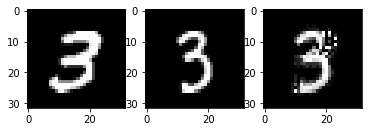

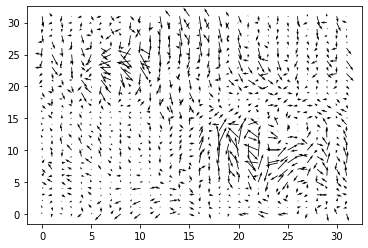

In [38]:
n_source = 0
n_target = 10
source_np = x_train[n_source, ...]
target_np = x_train[n_target, ...]

source = torch.reshape(torch.Tensor(source_np),(1,1,32,32))
target =  torch.reshape(torch.Tensor(target_np),(1,1,32,32))

y_source, flow = siren_reg_net.forward(source,target)
y_source_np = np.reshape(y_source.cpu().detach().numpy(),(32,32))
flow_np = flow.cpu().detach().numpy()

visu_img([source_np, target_np, y_source_np])
visu_flow([flow_np]) 

torch.Size([1024])


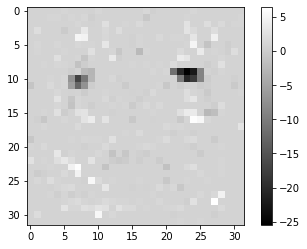

In [39]:
jac = compute_jacobian_matrix(siren_reg_net.grid, flow, add_identity=True)
det_jac = torch.det(jac)
print(det_jac.shape)
plt.figure()
pos = plt.imshow(np.reshape(det_jac.cpu().detach().numpy(),(32,32)),cmap="gray")
plt.colorbar()
plt.show()